For this project, we're developing a predictive model to forecast potential crime hotspots. This initiative aims to demonstrate the simplicity of creating predictive policing tools and to underscore the associated risks. Such models are increasingly being utilized by law enforcement agencies across the United States. Considering the universal potential for bias and the disproportionately higher likelihood of people of color being fatally encountered by police, the adoption of these models is a concerning trend.

**Project Overview:**

**Objective**: To create a predictive policing model to identify probable crime locations.<br/>
**Significance**: The project highlights both the ease of model creation and the inherent dangers, particularly in exacerbating systemic biases.<br/>
**Data Source**: The dataset for this analysis is sourced from the City of San Francisco's __[open data](https://datasf.org/opendata/)__ initiative, a valuable asset for data scientists focusing on public policy. The availability of such public, machine-readable data sets from more cities would be a significant step forward. <br/>
This project serves as a critical examination of how data science, while a powerful tool, can unintentionally perpetuate and amplify societal issues if not approached with caution.

In [ ]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np

The crime data for 2022 looks like this:

In [2]:
#Import Data
df = pd.read_csv("D:/Downloads/Police_Department_Incident_Reports.csv")
df.head(3)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Supervisor District 2012,Latitude,Longitude,Point
0,2022/01/01 12:00:00 AM,2022/01/01,00:00,2022,Saturday,2022/03/30 04:26:00 PM,115154309320,1151543,226052453,NaN,...,Open or Active,NaN,NaN,Taraval,NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/01 12:00:00 AM,2022/01/01,00:00,2022,Saturday,2022/04/01 12:29:00 AM,115152709320,1151527,226052522,NaN,...,Open or Active,NaN,NaN,Tenderloin,NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/01 12:00:00 AM,2022/01/01,00:00,2022,Saturday,2023/03/27 03:04:00 PM,125850110125,1258501,230213499,230861873.0,...,Open or Active,LEAVENWORTH ST \ TURK ST,24934000.0,Tenderloin,Tenderloin,5.0,6.0,37.782794,-122.414054,POINT (-122.41405376568504 37.78279444506034)


To simplify the process, I figure it will be a good idea to keep only the necessary data and discard the non-essential ones.

In [3]:
columns_to_keep = [
    'Incident Date', 
    'Incident Time', 
    'Incident Year', 
    'Incident Day of Week', 
    'Police District', 
    'Analysis Neighborhood'
]
data = df[columns_to_keep]
data.head()

,Incident Date,Incident Time,Incident Year,Incident Day of Week,Police District,Analysis Neighborhood
0,2022/01/01,00:00,2022,Saturday,Taraval,NaN
1,2022/01/01,00:00,2022,Saturday,Tenderloin,NaN
2,2022/01/01,00:00,2022,Saturday,Tenderloin,Tenderloin
3,2022/01/01,00:00,2022,Saturday,Southern,South of Market
4,2022/01/01,00:00,2022,Saturday,Tenderloin,Castro/Upper Market


In [4]:
# Convert 'Incident Date' to datetime for easier manipulation
data['Incident Date'] = pd.to_datetime(data['Incident Date'])

C:\Users\wojci\AppData\Local\Temp/ipykernel_8892/3422802280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Incident Date'] = pd.to_datetime(data['Incident Date'])


In [41]:
# Explanatory Data Analysis (EDA)

# First, convert 'Incident Time' to datetime format to easily extract the hour
data['Incident Time'] = pd.to_datetime(data['Incident Time'], format='%H:%M').dt.hour

# 1. Check for missing values
missing_values = data.isnull().sum()

# 2. Get the number of unique values in each column
unique_values = data.nunique()

# 3. Count of incidents by day of the week in each Analysis Neighborhood
incidents_by_day_neighborhood = data.groupby(['Analysis Neighborhood', 'Incident Day of Week']).size().reset_index(name='Daily Incidents Count')

# 4. Count of incidents by hour of the day in each Analysis Neighborhood
incidents_by_hour_neighborhood = data.groupby(['Analysis Neighborhood', 'Incident Time']).size().reset_index(name='Hourly Incidents Count')

# 5. Count of incidents by day of the week and hour of the day in each Analysis Neighborhood
incidents_by_day_hour_neighborhood = data.groupby(['Analysis Neighborhood', 'Incident Day of Week', 'Incident Time']).size().reset_index(name='Incidents Count')

# Merging the detailed counts back into the original data
data = data.merge(incidents_by_day_hour_neighborhood, how='left', on=['Analysis Neighborhood', 'Incident Day of Week', 'Incident Time'])

# Show the EDA results and a preview of the updated dataset
print("Missing Values:\n", missing_values)
print("\nUnique Values:\n", unique_values)
print("\nUpdated Data Preview:")
print(data.head())

Missing Values:
 Incident Date                0
Incident Time                0
Incident Year                0
Incident Day of Week         0
Police District              0
Analysis Neighborhood    16282
Incident Hour                0
Incidents Count          16282
dtype: int64

Unique Values:
 Incident Date            730
Incident Time             24
Incident Year              2
Incident Day of Week       7
Police District           11
Analysis Neighborhood     41
Incident Hour             24
Incidents Count          251
dtype: int64

Updated Data Preview:
  Incident Date  Incident Time  Incident Year Incident Day of Week  \
0    2022-01-01              0           2022             Saturday   
1    2022-01-01              0           2022             Saturday   
2    2022-01-01              0           2022             Saturday   
3    2022-01-01              0           2022             Saturday   
4    2022-01-01              0           2022             Saturday   

  Police Distric

**Missing Values**: The 'Analysis Neighborhood' column has 16,282 missing values. There are no missing values in the other columns of interest. <br/>
**Unique Values**:
- There are 730 unique incident dates and 1,440 unique incident times, reflecting the diversity of incidents reported.
- The dataset spans 2 unique years.
- Incidents are distributed across 7 days of the week and 11 police districts.
- There are 41 unique analysis neighborhoods identified.

C:\Users\wojci\AppData\Local\Temp/ipykernel_8892/1060512541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Incident Date'] = pd.to_datetime(data['Incident Date'])
C:\Users\wojci\AppData\Local\Temp/ipykernel_8892/1060512541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Incident Hour'] = pd.to_datetime(data['Incident Time'], format='%H:%M').dt.hour
C:\Users\wojci\AppData\Local\Temp/ipykernel_8892/1060512541.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

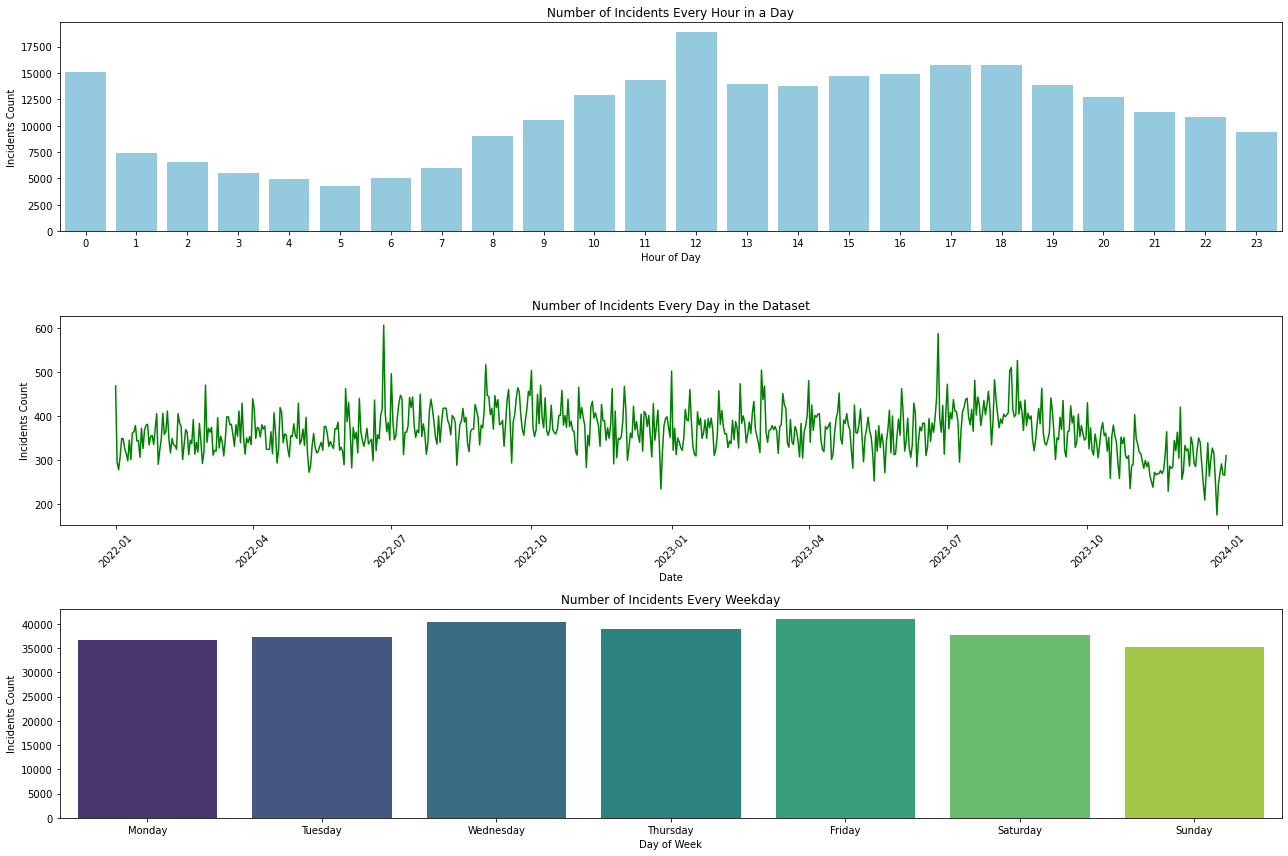

In [7]:
# Convert 'Incident Time' to hour for analysis and 'Incident Date' to datetime
data['Incident Date'] = pd.to_datetime(data['Incident Date'])
data['Incident Hour'] = pd.to_datetime(data['Incident Time'], format='%H:%M').dt.hour

# Number of incidents every hour in a day
incidents_by_hour = data.groupby('Incident Hour').size()

# Number of incidents every day in the dataset
incidents_by_date = data.groupby(data['Incident Date'].dt.date).size()

# Number of incidents every weekday
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data['Incident Day of Week'] = pd.Categorical(data['Incident Day of Week'], categories=weekdays, ordered=True)
incidents_by_weekday = data.groupby('Incident Day of Week').size()

# Plotting
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
sns.barplot(x=incidents_by_hour.index, y=incidents_by_hour.values, color='skyblue')
plt.title('Number of Incidents Every Hour in a Day')
plt.xlabel('Hour of Day')
plt.ylabel('Incidents Count')

plt.subplot(3, 1, 2)
plt.plot(incidents_by_date.index, incidents_by_date.values, color='green')
plt.title('Number of Incidents Every Day in the Dataset')
plt.xlabel('Date')
plt.ylabel('Incidents Count')
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.barplot(x=incidents_by_weekday.index, y=incidents_by_weekday.values, palette='viridis')
plt.title('Number of Incidents Every Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Incidents Count')

plt.tight_layout()
plt.show()

From the above charts, we can read that: <br/>
- The highest number of reported incidents occurs between 12 and 7 pm and at midnight.
- In the analyzed time period, the number of reports in the study area has been declining since August 2023, and that there are peaks in early July which may be related to the Independence Day celebration on July 4th.
- There are no significant differences for the day on which the events happen.

In the realm of data science, the division of data into training and testing sets is a ritual as sacred as any. Traditionally, this split follows a random pattern, with a general rule of thumb allocating 70% for training purposes and the remaining 30% for testing. Yet, when the whispers of time echo through our datasets, we're nudged towards a chronological separation, embarking on a quest to peer into the future. In this tale, the year 2022 becomes our crystal ball, offering insights to predict the unfolding mysteries of 2023.<br/><br/>

Imagine the stage of testing as the realm where the enchantment of machine learning reveals its power. Reflecting on my days in the halls of demography graduate school, I recall the crafting of predictions, much like casting spells into the void, with their potency unknown until the future unfurls. These predictions, if cloaked in the guise of reason and intuition, were heralded with accolades, their accuracy a question left unasked.<br/><br/>

As we venture further, armed with our data now segmented into realms of training and testing, we stand ready to summon an array of models from the vast arsenal of machine learning. These models, each with its unique alchemy of tuning and tweaking (known to the initiated as hyperparameters), await our command. For the sake of our journey, we shall invoke them in their most primal form, unadorned with the complexities of optimization.

In [59]:
# Drop rows with missing 'Analysis Neighborhood' or 'Incidents Count' as they cannot be used for prediction
data_clean = data.dropna(subset=['Analysis Neighborhood', 'Incidents Count_x'])
data_clean.rename(columns={'Incidents Count_y': 'Total Incidents'}, inplace=True)  # Rename for clarity

# Initialize OneHotEncoder with handle_unknown='ignore' to deal with unseen categories in the test set
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Fit the encoder on the data_clean to prepare for handling both known and unknown categories
encoder.fit(data_clean[['Incident Day of Week', 'Analysis Neighborhood', 'Incident Time']])  # Now includes 'Incident Time'

# Transform 'Incident Day of Week', 'Analysis Neighborhood', and 'Incident Time' using the fitted encoder
encoded_features = encoder.transform(data_clean[['Incident Day of Week', 'Analysis Neighborhood', 'Incident Time']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Incident Day of Week', 'Analysis Neighborhood', 'Incident Time']))

# Concatenate encoded features with the 'Incident Year' and 'Incidents Count'
data_prepared = pd.concat([data_clean[['Incident Year']].reset_index(drop=True), encoded_df, data_clean['Total Incidents'].reset_index(drop=True)], axis=1)

# Split the dataset based on the year
data_train = data_prepared[data_prepared['Incident Year'] == 2022]
data_test = data_prepared[data_prepared['Incident Year'] == 2023]

# Separate features and target variable
X_train = data_train.drop(['Total Incidents', 'Incident Year'], axis=1)
y_train = data_train['Total Incidents']
X_test = data_test.drop(['Total Incidents', 'Incident Year'], axis=1)
y_test = data_test['Total Incidents']

D:\programfiles\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
D:\programfiles\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 1. Linear Regression

Our first ally is a venerable technique, born in the early 19th century—a time of discovery and intellectual fervor. Linear Regression, with its simplicity and swiftness, seeks to chart a course through the data, drawing a line that strives for harmony among the scattered points. Its value lies not just in its predictive capabilities, but in the transparency of its wisdom. By consulting this model, trained with the essence of 2022, we can predict the dance of crime numbers in 2023, achieving a vision that aligns with the threads of reality at an astonishing accuracy of 84%. This mark sets a foundation upon which we aim to build, exploring newer magics to enhance our foresight.

Thus, our expedition into the future begins with the hope of unveiling deeper truths hidden within the folds of time and data.

In [58]:
# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
predictions = lr_model.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}, R^2: {r2}')

RMSE: 29.94985414351958, R^2: 0.8439623508581918


## 2. Random Forest Regressor

Venturing deeper into the enchanted forest of machine learning, we stumble upon the mystical realm of the Random Forest Regressor. Imagine a gathering of wise old trees, each a Decision Tree, rooted in the fertile ground of our dataset. These aren't ordinary trees; they're conjurers of predictions, working in unison to unveil the secrets of future crimes.<br/>

Let's demystify the magic of a single Decision Tree first. It's akin to a sage, pondering over the data, seeking the paths it may naturally divide along, and choosing outcomes with the wisdom of ages. Picture this: our sage discerns that Wednesdays are cloaked in shadows, bearing the weight of increased crime, and the Tenderloin district whispers tales of mischief more than any other place. Guided by these insights, it queries the fabric of reality: "Did the event occur on a Wednesday?" A "yes" conjures a vision of higher crime rates; a "no" paints a calmer picture. "Was it in the Tenderloin?" Again, affirmation brings predictions of heightened activity, while denial suggests tranquility. This process of inquiry and prediction continues, weaving through the data to forecast the outcome for each variable presented.<br/>

Now, imagine not one, but an entire assembly of these sages—this is the Random Forest. Each tree, drawing from different shards of the same reality, offers its prophecy. Together, they form a chorus, their voices harmonizing to produce a prediction more accurate and robust than any could alone.<br/>

Let's embark on this journey with the Random Forest Regressor, guiding us through the tangled paths of data, and see how close we can come to capturing the essence of tomorrow's tales. The adventure promises not only to illuminate the patterns of crime but to showcase the power of unity in diversity, as the forest's collective wisdom charts a course through the unknown.<br/>

In [47]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
predictions_rf = rf_model.predict(X_test)
rmse_rf = sqrt(mean_squared_error(y_test, predictions_rf))
r2_rf = r2_score(y_test, predictions_rf)
print(f'Random Forest RMSE: {rmse_rf}, R^2: {r2_rf}')

Random Forest RMSE: 0.2602218843465641, R^2: 0.9999882204795624


Achieving an accuracy of 0.9999882204795624 is like hitting the bullseye from a thousand leagues away—a feat of precision so extraordinary it borders on the mythical. This level of accuracy, while impressive, beckons us to tread carefully on our path, for it whispers the cautionary tale of overfitting.<br/>

Overfitting is akin to memorizing the map of the stars without understanding the dance of the cosmos—it means our model might perform spectacularly on known data but could falter when faced with the unforeseen. As we wield this powerful tool, we must balance our ambition with humility, ensuring that our journey through the realms of prediction remains both enlightened and grounded.

## 3. K-Nearest Neighbors

Venturing further into the labyrinth of predictive models, we encounter the enigmatic K-Nearest Neighbors (KNN), a model that subtly shifts the narrative towards the mystical. KNN operates on a principle both simple and profound: it seeks guidance from the company one keeps. Yet, as we delve into its workings, the clarity of its methodology contrasts with the opacity of its decisions.

Imagine wandering through a dense fog, where silhouettes of familiarity guide your steps. You're seeking the path to a destination known only as "Wednesday, Tenderloin, 10pm." As you pause, uncertain, two figures emerge from the mist—"Wednesday, Tenderloin, 11pm" and "Wednesday, Tenderloin, 9pm." They whisper tales of nights similar to yours, their voices blending to offer a vision of what lies ahead. This confluence of past journeys illuminates your path, providing an insight grounded in the experiences of those nearest to you.

KNN embodies this journey of connection, drawing from the essence of its closest kin to forecast the unseen. It's a dance of shadows and light, where the past's echo shapes the future's whisper, and the path forward is paved with the wisdom of proximity. Let us step forward, guided by these spectral figures, to uncover what tales the night holds.

In [48]:
# Initialize and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
predictions_knn = knn_model.predict(X_test)
rmse_knn = sqrt(mean_squared_error(y_test, predictions_knn))
r2_knn = r2_score(y_test, predictions_knn)
print(f'KNN RMSE: {rmse_knn}, R^2: {r2_knn}')

KNN RMSE: 6.8569401263307075, R^2: 0.9918209909299609


In the realm of our quest, achieving an accuracy of 0.9918209909299609 is like discovering an ancient map that reveals paths through forests and across seas with near-perfect precision. This map, with its intricate details, guides us through the terrain of prediction with a sureness that is both exhilarating and daunting.<br/>

Yet, in this landscape of high accuracy, a shadow looms—the specter of overfitting. It whispers of a map so finely drawn to the trails once traveled that it may falter when new, uncharted paths emerge. Just as a navigator must be wary of relying too heavily on a single guide, we must tread lightly, ensuring our map is not so tailored to familiar journeys that it loses its way in the face of the unknown.<br/>

Let this be a beacon as we navigate the vast oceans of data, a reminder to balance our sail and compass, so our voyage remains true not just in the waters we know but in the unexplored depths that lie ahead.

## 4. XGBoost
In the grand tournament of algorithms, where data warriors vie for supremacy, XGBoost emerges as a champion heralded for its conquests in the arenas of __[Kaggle](https://www.kaggle.com)__. Picture it not as a lone hero, but as a battalion of trees, an army where each unit learns from the last, marching forward with increasing precision and strength.<br/>

Imagine a forest where each tree is not planted by chance but chosen for its ability to shield the weakest among them, correcting the missteps of its predecessors. As one tree rises, it casts light on its shadows, allowing the next to grow in a spot better suited to the sun. With each iteration, the forest becomes denser, stronger, and more adept at protecting its domain.<br/>

XGBoost crafts its legion with care, each tree building on the lessons of the last, aiming to fortify where previous defenses were weak. This iterative march, this relentless quest for improvement, is what sets XGBoost apart, making it a legend in the lore of machine learning.


In [49]:
# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
predictions_xgb = xgb_model.predict(X_test)
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
r2_XGB = r2_score(y_test, predictions_xgb)
print(f'XGBoost RMSE: {rmse_xgb}, R^2: {r2_XGB}')

XGBoost RMSE: 16.05753176905329, R^2: 0.9551463742518361


Navigating the seas of prediction with an accuracy of 0.9551463742518361 is akin to steering a ship with a compass so precise, it can navigate through storms and mists with a confidence that borders on the audacious. This level of accuracy, while a testament to the skill of our navigation, casts a shadow of caution—overfitting, the siren call that can lead even the most stalwart ship astray.<br/>

This tale reminds us that while our compass is true under the stars we know, it is in the uncharted waters, under unfamiliar constellations, that our true test awaits. Overfitting whispers of a compass too finely tuned to the currents we've sailed before, risking misguidance in new waters.<br/>

Thus, as we chart our course with this remarkable tool, we do so with an eye to the horizon, ensuring our journey remains steadfast not only in the realms we know but in the adventures that lie beyond the map's edge.

## 5. Deep Learning — Multilayer Perceptron

In our journey through the mystical landscape of machine learning, we find ourselves before the enigmatic Multilayer Perceptron (MLP) Regressor, a spellcaster of deep learning whose insights are veiled in shadow. This arcane model, structured with four hidden layers and a hundred nodes each, holds the power to predict with remarkable precision but cloaks its wisdom in mystery.<br/>

As we wield this potent form of magic, we stand at a crossroads. The might of our predictions impacts lives, yet the reasons behind these forecasts remain locked within the model's depths, a riddle wrapped in an enigma. This is the paradox of our adventure: the stronger the spell, the harder it becomes to trace its origins.<br/>

In choosing the path of the MLP Regressor, we embrace the power of prediction but also confront the challenge of the unknown. It's a reminder that with great power comes the responsibility to seek understanding, to ensure that our interventions are as transparent as they are transformative. As guardians of this powerful tool, our mission is to navigate its mysteries with care, ensuring that our quest enhances the realm of knowledge without losing sight of the light.

In [63]:
# Initialize and train the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(100,100, 100, 100), activation='relu', solver='adam', max_iter=200, random_state=444)
mlp_model.fit(X_train, y_train)

# Predict and evaluate
predictions_mlp = mlp_model.predict(X_test)
rmse_mlp = sqrt(mean_squared_error(y_test, predictions_mlp))
r2_mlp = r2_score(y_test, predictions_mlp)
print(f'MLP RMSE: {rmse_mlp}, R^2: {r2_mlp}')

MLP RMSE: 0.763864972978732, R^2: 0.9998984983348347


In our exploration of predictive modeling, we embarked on an adventure with five distinct models, revealing an uncanny ability to forecast crime patterns with impressive accuracy. This journey hinted at a curious fact: the broader strokes of Analysis Neighborhoods led us to wonder if more granular guides like zip codes might unveil a nuanced, yet still insightful, landscape.<br/>

Our curiosity didn't stop there. We envisaged augmenting our arsenal with variables uncharted—weather patterns, proximity to liquor stores, shelters, and demographic tapestries, using historical data as our guide, perhaps from as far back as 2018, to refine our foresight.<br/>

However, our quest for simplicity in prediction brought us face-to-face with a paradox: the ease of prediction came at the expense of explainability. As we pondered deploying more guardians based on these forecasts, we realized that their mere presence might illuminate more shadows of crime, irrespective of the actual prevalence. This phenomenon, a self-fulfilling prophecy, highlights the intricacies of predictive policing and the potential for perpetuating biases.<br/>

This narrative is a call to arms for the wielders of data. While we revel in the power of our models to predict and perhaps prevent, we must tread carefully, ensuring our tools illuminate paths to a better future rather than casting long shadows over it. The quest for accurate models is not just technical but ethical, urging us to navigate the delicate balance between foresight and oversight.<br/>